In [3]:
import pandas as pd

df = pd.read_csv('data/StudentPerformanceFactors.csv')

print(df.columns)

# print the type of each column
print(df.dtypes)
print(df['Sleep_Hours'].unique())

Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
       'Previous_Scores', 'Motivation_Level', 'Internet_Access',
       'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
       'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
       'Parental_Education_Level', 'Distance_from_Home', 'Gender',
       'Exam_Score'],
      dtype='object')
Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity  

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Encode categorical features
df_encoded = df.copy()

# Encode categorical variables using LabelEncoder
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df[column])
    label_encoders[column] = le  # Save the label encoder for potential inverse transformations

# 2. Split data into features and target
X = df_encoded.drop('Exam_Score', axis=1)
y = df_encoded['Exam_Score']

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train an XGBoost regressor
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=1000, 
    learning_rate=0.1, 
    max_depth=8,
    early_stopping_rounds=50
)
xg_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=2)

# 5. Make predictions on the test set
y_pred = xg_reg.predict(X_test)

# 6. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


[0]	validation_0-rmse:3.53517
[2]	validation_0-rmse:3.17548
[4]	validation_0-rmse:2.91433
[6]	validation_0-rmse:2.71606
[8]	validation_0-rmse:2.57426
[10]	validation_0-rmse:2.47318
[12]	validation_0-rmse:2.39252
[14]	validation_0-rmse:2.34176
[16]	validation_0-rmse:2.29417
[18]	validation_0-rmse:2.25797
[20]	validation_0-rmse:2.23824
[22]	validation_0-rmse:2.21728
[24]	validation_0-rmse:2.19950
[26]	validation_0-rmse:2.18191
[28]	validation_0-rmse:2.16880
[30]	validation_0-rmse:2.15963
[32]	validation_0-rmse:2.15142
[34]	validation_0-rmse:2.14253
[36]	validation_0-rmse:2.13489
[38]	validation_0-rmse:2.12884
[40]	validation_0-rmse:2.12269
[42]	validation_0-rmse:2.11698
[44]	validation_0-rmse:2.11374
[46]	validation_0-rmse:2.10753
[48]	validation_0-rmse:2.10192
[50]	validation_0-rmse:2.10006
[52]	validation_0-rmse:2.09741
[54]	validation_0-rmse:2.09762
[56]	validation_0-rmse:2.09646
[58]	validation_0-rmse:2.09607
[60]	validation_0-rmse:2.09392
[62]	validation_0-rmse:2.09330
[64]	validati

 93%|=================== | 1232/1322 [00:14<00:01]       

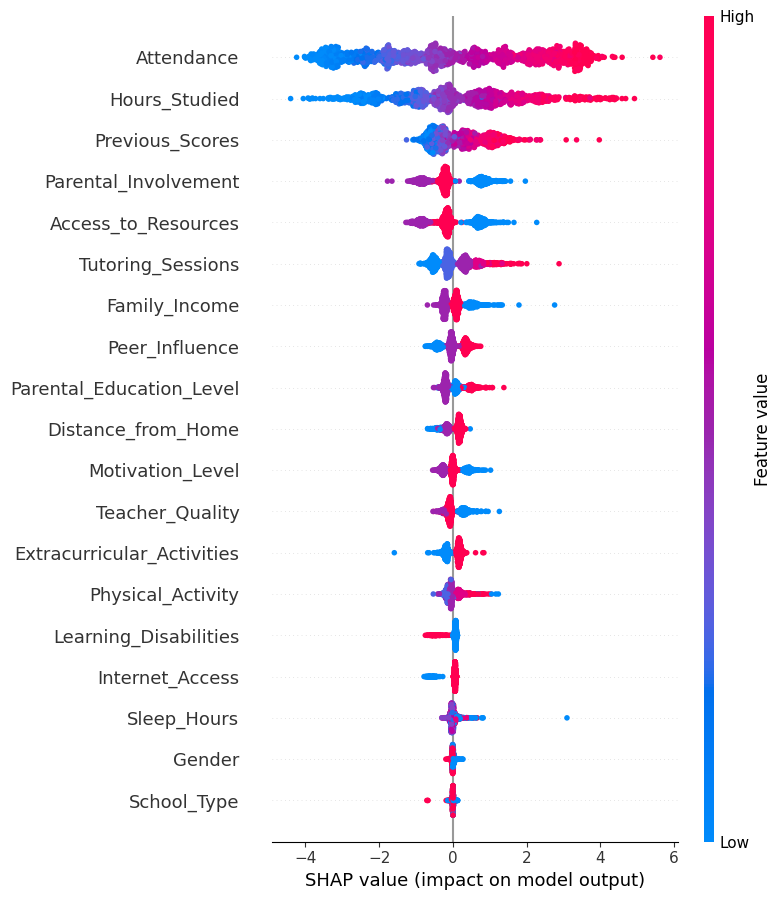

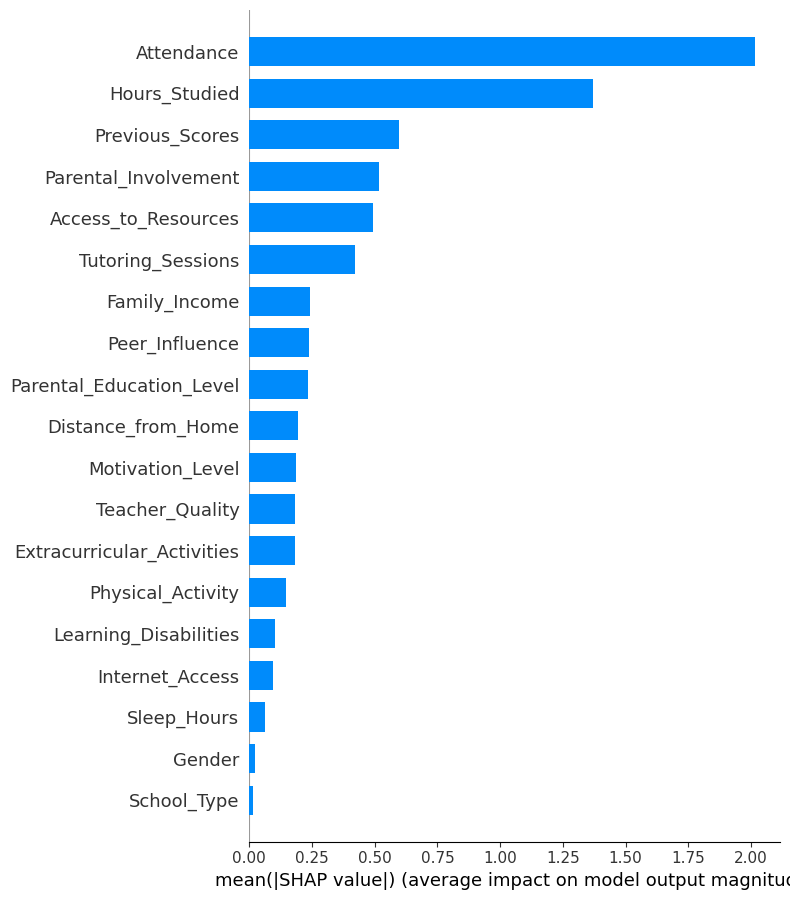

TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

In [7]:
import shap

# 1. Initialize the SHAP explainer
explainer = shap.Explainer(xg_reg, X_train)

# 2. Calculate SHAP values for the test set
shap_values = explainer(X_test)

# save the SHAP values for later use with the column names as pickle
import pickle

with open('data/shap_values.pkl', 'wb') as f:
    pickle.dump({
        'shap_values': shap_values,
        'X_test': X_test
    }, f)


# 3. Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, show=False)

# 4. Feature importance plot based on mean absolute SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 5. SHAP dependence plot for a specific feature
shap.dependence_plot("Attendance", shap_values, X_test)

# 6. Force plot for a single prediction (useful for local interpretation)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib=True)